# Le Meridien Performance Explorer

Goal: explain how Le Meridien shows up in this survey using clean tables, labeled visuals, and plain-language interpretations. Each section states the sample size so you immediately know how reliable the view is.

**Data facts**
- Source file: `data/Hotel Brands_raw_data_indiv_lvl.csv` with placeholder nulls ['#NULL!', 'NULL'] converted to `NaN`.
- Structure: 385 respondents × 441 fields (72,100 missing cells across 433 columns).
- Meridien reach: 361 respondents (93.8%) logged ≥1 Meridien stay, but only 13 completed the entire Meridien attitude battery plus SCR.


### Meridien Features

- `Meridiennights`: Total nights the respondent spent at any Le Meridien during the recall window.
- `safeMeridien`: Agreement rating for “I feel safe at Le Meridien.”
- `sucMeridien`: Agreement rating for “Le Meridien helps me be successful/get things done.”
- `specMeridien`: Perception that Le Meridien feels special or distinctive.
- `cfreeMerid`: “Carefree/relaxed at Le Meridien” agreement rating.
- `wellMerid`: “Le Meridien makes me feel welcomed/well” sentiment.
- `clMerid`: Cleanliness/clarity perception for the brand.
- `wmMerid`: Warm & modern impression (“warm modern” shorthand).
- `pamMerid`: Feeling of being pampered or indulged at Le Meridien.
- `Meridienpen`: Penalty score—how strongly respondents said they would avoid the brand (higher = worse).
- `Meridienpf`: Preference score—how often Le Meridien is the first-choice brand (higher = better).
- `SCRmerid`: Share of consideration/recommendation (0–1 advocacy score for the brand).

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from helper import count_nulls

sns.set_theme(style='whitegrid', context='talk')
pd.options.display.float_format = '{:,.2f}'.format


## 1. Load once, reuse everywhere
The cell below ingests the CSV, shows a quick preview, and stores the dataframe as `df` for the rest of the notebook.

In [2]:
DATA_PATH = Path('data/Hotel Brands_raw_data_indiv_lvl.csv')
NA_VALUES = ['#NULL!','NULL']

df = pd.read_csv(DATA_PATH, na_values=NA_VALUES)
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns")
df.head()


Loaded 385 rows and 441 columns


,StartDate,EndDate,Status,Progress,Duration__in_seconds_,Finished,RecordedDate,ResponseId,Q_RecaptchaScore,totalnights,...,SCRascend,SCRmerid,SCRsher,SCRwestin,SCRwynd,SCRdolce,SCRmarriott,SCRhyatt,SCRhilt,SCRemb
0,1/16/20 22:16,1/16/20 22:20,0,100.00,237.00,1,1/16/20 22:20,R_1qUS7Sta2jPMOi1,0.90,NaN,...,0.06,0.04,0.01,0.03,0.01,0.03,0.03,0.03,0.04,0.03
1,1/15/20 18:11,1/15/20 18:12,0,19.00,95.00,0,1/17/20 18:12,R_1CfgGpDe1JJWaeY,0.90,100.00,...,NaN,NaN,0.34,NaN,NaN,NaN,NaN,NaN,0.34,NaN
2,1/15/20 22:03,1/15/20 22:22,0,100.00,"1,109.00",1,1/15/20 22:22,R_2cbmKnt8yU6NtWB,0.10,228.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06
3,1/16/20 0:49,1/16/20 1:13,0,100.00,"1,489.00",1,1/16/20 1:13,R_3KO67z2x3hBoVQj,0.90,168.00,...,NaN,NaN,0.12,0.12,NaN,NaN,0.03,0.12,0.18,0.12
4,1/15/20 17:51,1/15/20 17:55,0,24.00,231.00,0,1/17/20 17:55,R_0VNtuuOPIzqy2M9,0.90,80.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,0.33


## 2. Missing data map
Counting nulls immediately tells us which questions were skipped. We'll focus on columns with enough volume to make directional calls and flag sparse ones so you can decide whether to collect more data later.

In [3]:
null_overview = count_nulls(df)
display(null_overview.head(20))


,nulls,percent_missing
Q24_5_TEXT,378,0.98
Meridienpf,366,0.95
SCRmerid,366,0.95
SCRdolce,365,0.95
Indigopf,365,0.95
Dolcepf,365,0.95
SCRindigo,365,0.95
SCRascend,364,0.95
Ascendpf,364,0.95
SCRmain,362,0.94


## 3. Trip mix baseline
Median respondent logged 8 total nights in the last 12 months (2 business vs 6 leisure). There's a long tail up to 228 nights, so I'll show full distributions instead of only means.

,count,mean,50%,75%,max
totalnights,384.00,12.35,8.00,14.25,228.00
busnights,372.00,4.96,2.00,5.00,218.00
leisnights,384.00,7.55,6.00,10.00,100.00


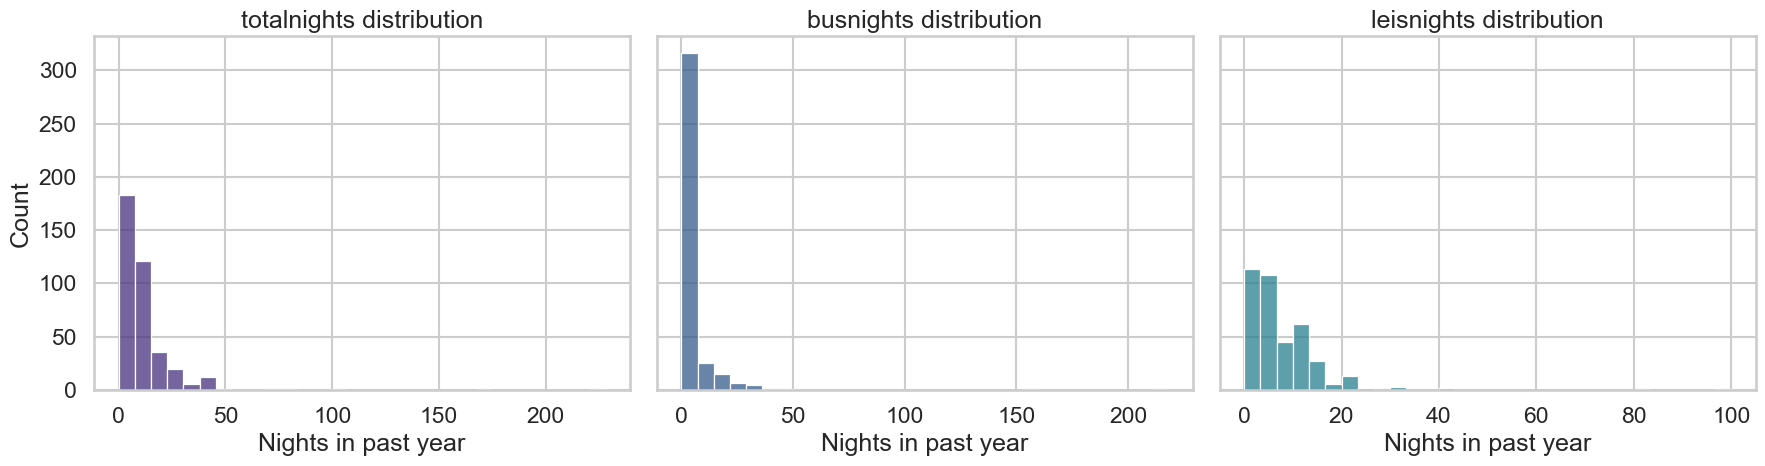

In [14]:
trip_cols = ['totalnights','busnights','leisnights']
trip_summary = df[trip_cols].describe().T[['count','mean','50%','75%','max']]
display(trip_summary)

fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, col in enumerate(trip_cols):
    sns.histplot(df[col], bins=30, ax=ax[idx], color=sns.color_palette('viridis')[idx])
    ax[idx].set_title(f'{col} distribution')
    ax[idx].set_xlabel('Nights in past year')
plt.tight_layout()
plt.show()


## 4. Meridien engagement footprint
Key stats:
- Average stays per respondent: 1.12 (median 1, max 5).
- 361 people touched the brand at least once; charts below show how concentrated that engagement is.


,count,mean,50%,75%,max
Meridiennights,361.00,1.12,1.00,1.00,5.00


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_55072/1196331629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Meridiennights', data=df, palette='mako', ax=ax)


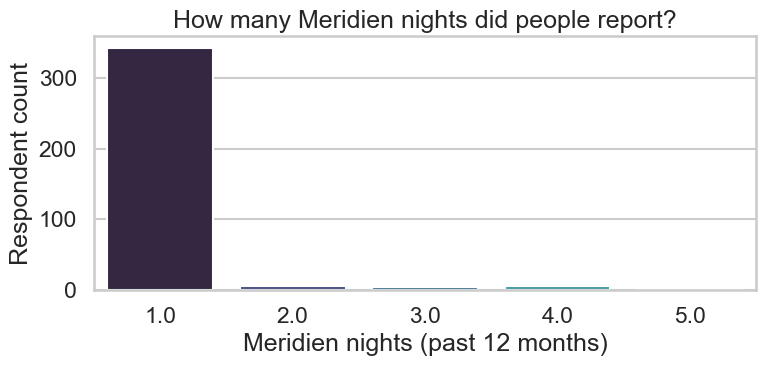

,Meridiennights,count,percentage
0,1.00,342,0.95
1,2.00,6,0.02
2,3.00,5,0.01
3,4.00,6,0.02
4,5.00,2,0.01


,Meridiennights,totalnights,percentage
0,1.00,"4,181.00",0.00
1,2.00,69.00,0.03
2,3.00,65.00,0.05
3,4.00,109.00,0.04
4,5.00,15.00,0.33


In [19]:
mer_summary = df[['Meridiennights']].describe().T[['count','mean','50%','75%','max']]
display(mer_summary)

fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='Meridiennights', data=df, palette='mako', ax=ax)
ax.set_title('How many Meridien nights did people report?')
ax.set_xlabel('Meridien nights (past 12 months)')
ax.set_ylabel('Respondent count')
plt.tight_layout()
plt.show()

# create a table that shows count by Meridiennights
mer_counts = df['Meridiennights'].value_counts().sort_index().reset_index()
mer_counts.columns = ['Meridiennights', 'count']
mer_counts['percentage'] = mer_counts['count'] / mer_counts['count'].sum()
display(mer_counts)

#create a table that shows in relation to total nights
mer_summary = df[['Meridiennights', 'totalnights']].groupby('Meridiennights').sum().reset_index()
mer_summary['percentage'] = mer_summary['Meridiennights'] / mer_summary['totalnights']
display(mer_summary)

## 5. Brand overlap among Meridien guests
People rarely stay with Meridien in isolation. This section filters to respondents with ≥1 Meridien night and displays which competitor brands they also patronized most often.

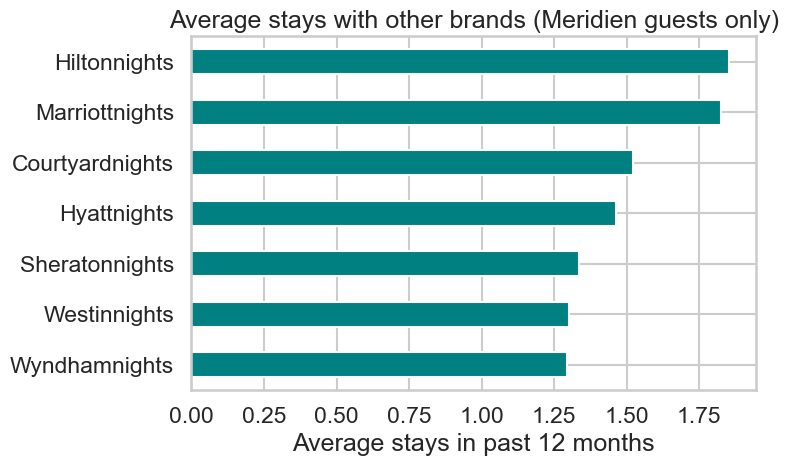

Hiltonnights      1.85
Marriottnights    1.82
Courtyardnights   1.52
Hyattnights       1.46
Sheratonnights    1.33
Westinnights      1.30
Wyndhamnights     1.29
dtype: float64

In [6]:
with_mer = df[df['Meridiennights'] > 0]
compare_cols = ['Hyattnights','Hiltonnights','Westinnights','Marriottnights','Sheratonnights','Wyndhamnights','Courtyardnights']
co_means = with_mer[compare_cols].mean().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8,5))
co_means.plot(kind='barh', color='teal', ax=ax)
ax.set_title('Average stays with other brands (Meridien guests only)')
ax.set_xlabel('Average stays in past 12 months')
plt.tight_layout()
plt.show()

co_means.sort_values(ascending=False)


## 6. What drives Meridien's SCR?
Only 13 complete records exist, so treat this as exploratory signal. Even with that caveat, safety/warmth statements dominate the correlation ranking (see bar chart).

Complete Meridien attitude + SCR records: 13


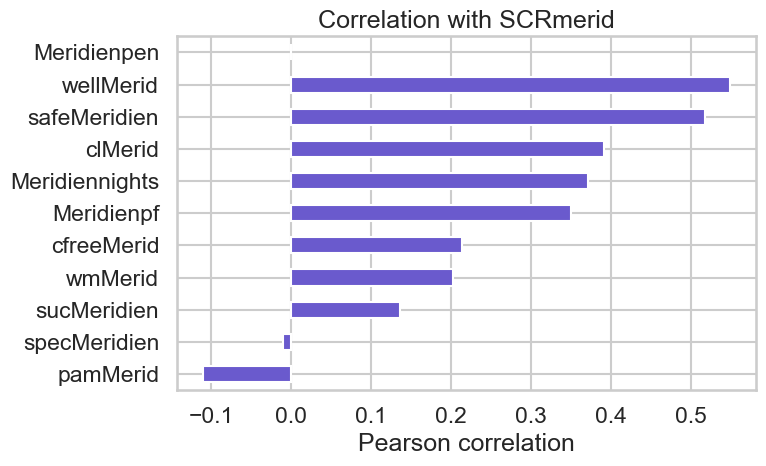

wellMerid         0.55
safeMeridien      0.52
clMerid           0.39
Meridiennights    0.37
Meridienpf        0.35
cfreeMerid        0.21
wmMerid           0.20
sucMeridien       0.14
specMeridien     -0.01
pamMerid         -0.11
Meridienpen        NaN
Name: SCRmerid, dtype: float64

In [7]:
mer_cols = ['Meridiennights','safeMeridien','sucMeridien','specMeridien','cfreeMerid','wellMerid','clMerid','wmMerid','pamMerid','Meridienpen','Meridienpf','SCRmerid']
mer_stack = df[mer_cols].dropna()
print(f"Complete Meridien attitude + SCR records: {len(mer_stack)}")

corr_series = mer_stack.corr(numeric_only=True)['SCRmerid'].drop('SCRmerid').sort_values()

fig, ax = plt.subplots(figsize=(8,5))
corr_series.plot(kind='barh', color='slateblue', ax=ax)
ax.set_title('Correlation with SCRmerid')
ax.set_xlabel('Pearson correlation')
plt.tight_layout()
plt.show()

corr_series.sort_values(ascending=False)


## 7. SCR scorecard vs. peer set
Here we benchmark Meridien against other premium brands. Each bar shows the average SCR among respondents who answered that brand's SCR question (Meridien has 19 such responses with an average of 0.047).

,count,mean,50%,75%,max
SCRmerid,19.00,0.05,0.04,0.06,0.14
SCRhyatt,97.00,0.22,0.15,0.30,1.00
SCRhilt,161.00,0.29,0.20,0.35,1.00
SCRwestin,54.00,0.14,0.10,0.16,1.00
SCRmarriott,176.00,0.26,0.20,0.34,1.00
SCRsher,67.00,0.18,0.11,0.22,1.00


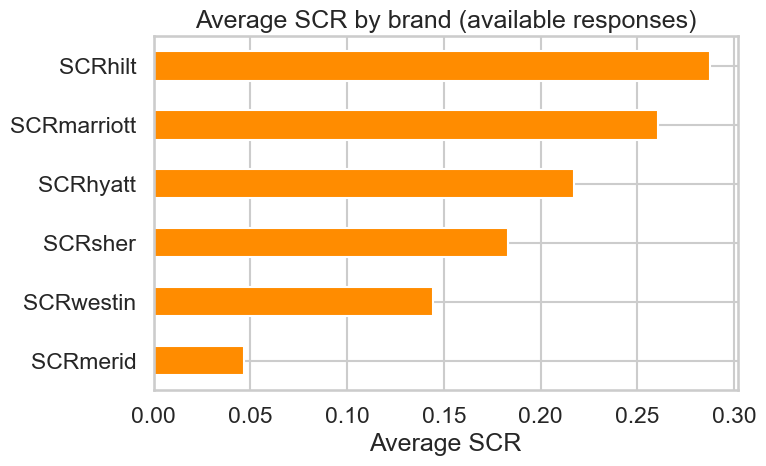

In [8]:
scr_cols = ['SCRmerid','SCRhyatt','SCRhilt','SCRwestin','SCRmarriott','SCRsher']
scr_summary = df[scr_cols].describe().T[['count','mean','50%','75%','max']]
display(scr_summary)

scr_means = df[scr_cols].mean().sort_values()
fig, ax = plt.subplots(figsize=(8,5))
scr_means.plot(kind='barh', color='darkorange', ax=ax)
ax.set_title('Average SCR by brand (available responses)')
ax.set_xlabel('Average SCR')
plt.tight_layout()
plt.show()


## 8. Penalty vs. preference intent
Penalty = "I would never stay there" (lower is better). Preference = "This would be my first choice" (higher is better). Meridien's averages (0.05 penalty, 3.97 preference with a median of 3.5) show indifference rather than rejection.

,count,mean,50%,75%,max
Meridienpen,361.00,0.05,0.00,0.00,1.00
Meridienpf,19.00,3.97,3.50,5.50,8.00


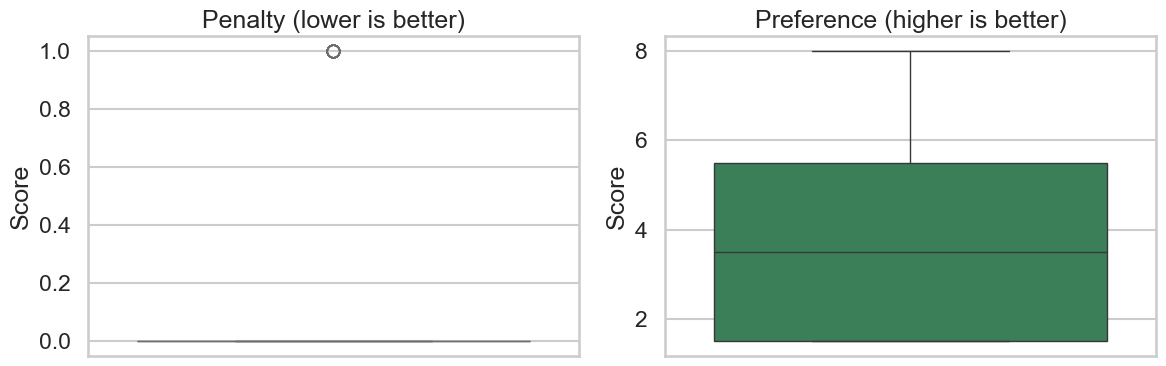

In [9]:
intent_cols = ['Meridienpen','Meridienpf']
intent_summary = df[intent_cols].describe().T[['count','mean','50%','75%','max']]
display(intent_summary)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(y=df['Meridienpen'], ax=ax[0], color='salmon')
ax[0].set_title('Penalty (lower is better)')
ax[0].set_ylabel('Score')

sns.boxplot(y=df['Meridienpf'].dropna(), ax=ax[1], color='seagreen')
ax[1].set_title('Preference (higher is better)')
ax[1].set_ylabel('Score')

plt.tight_layout()
plt.show()


## 9. Business vs. leisure lens
To see whether trip purpose changes the story, I bucket each respondent by whichever night count (business vs leisure) is larger and compare Meridien nights and SCR.

Meridiennights      SCRmerid     
                           count mean    count mean
segment                                            
Balanced/No stays             34 1.18        3 0.03
Business leaning              75 1.13        5 0.03
Leisure leaning              252 1.10       11 0.06

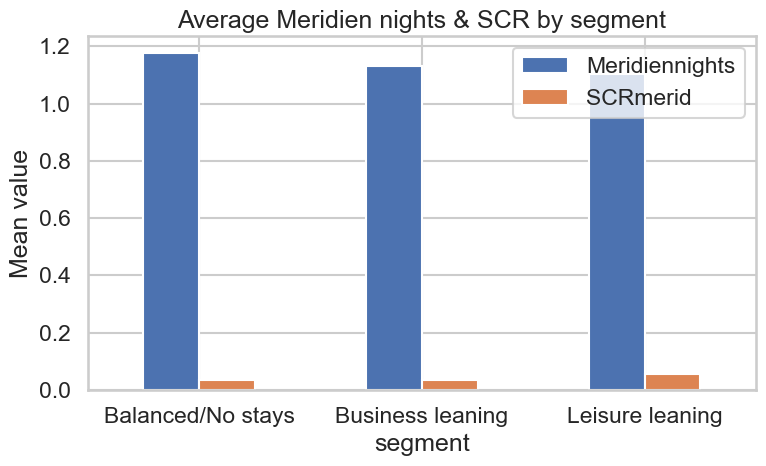

In [10]:
segment_df = df[['totalnights','busnights','leisnights','Meridiennights','SCRmerid']].copy()
segment_df['segment'] = np.where(segment_df['busnights'] > segment_df['leisnights'], 'Business leaning',
                          np.where(segment_df['leisnights'] > segment_df['busnights'], 'Leisure leaning', 'Balanced/No stays'))
segment_summary = segment_df.groupby('segment')[['Meridiennights','SCRmerid']].agg(['count','mean'])
display(segment_summary)

segment_means = segment_df.groupby('segment')[['Meridiennights','SCRmerid']].mean()
segment_means.plot(kind='bar', figsize=(8,5), color=['#4c72b0','#dd8452'])
plt.title('Average Meridien nights & SCR by segment')
plt.ylabel('Mean value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 10. Takeaways you can repeat externally
1. **Awareness, not hostility, is the issue.** 361 respondents said they'd stayed with Meridien, yet only 19 reached the SCR question and their average score is 0.047. Lack of exposure drives the drop-off more than active dislike (penalty mean 0.05).
2. **Warmth and safety move the needle.** In the limited SCR sample, `wellMerid` and `safeMeridien` correlations exceed 0.5, so emphasizing hospitality cues should lift advocacy faster than product/price stats.
3. **Guests overlap with other premium flags.** Among Meridien stayers, Hilton and Marriott average almost two stays each, suggesting share-of-wallet gains should target loyalty members already in those ecosystems.
4. **Leisure leaning guests are happiest.** Leisure-heavy respondents still average only ~1 Meridien stay but deliver the highest SCR (~0.056), so leisure-first offers are the fastest route to better scores.
